# Testing SXS catalogue load

Objectives:

1. Test SXS simulation waveform loaded through nrc-catalogue-tools.

## Load the library

In [1]:
import sys

#p1 = "/home/vaishakp/Codes/custom_libraries/nr-catalog-tools"
#libpath = '/mnt/pfs/vaishak.p/Projects/Codes/custom_libraries/nr-catalog-tools'
libpath = '/home/vaishakprasad/Documents/Codes/nr-catalog-tools-vp'

if libpath not in sys.path:
    sys.path.append(libpath)

print(sys.path)

['/home/vaishakprasad/Documents/Codes/nrcattools-local/test/notebooks', '/home/vaishakprasad/Documents/Codes/config', '/home/vaishakprasad/Documents/Codes/waveformtools', '/home/vaishakprasad/Documents/Codes/qlmtools', '/home/vaishakprasad/Documents/Codes/nrcattools-local/test/notebooks', '/home/vaishakprasad/soft/anaconda3/envs/nrcat/lib/python310.zip', '/home/vaishakprasad/soft/anaconda3/envs/nrcat/lib/python3.10', '/home/vaishakprasad/soft/anaconda3/envs/nrcat/lib/python3.10/lib-dynload', '', '/home/vaishakprasad/soft/anaconda3/envs/nrcat/lib/python3.10/site-packages', '/home/vaishakprasad/Documents/Codes/nr-catalog-tools-vp']


## Display the environment

In [2]:
%%bash
python --version
conda info --envs | grep '*'

Python 3.10.11
nrcat                 *  /home/vaishakprasad/soft/anaconda3/envs/nrcat


# Method I : through nr-catalogue-tools

In [3]:
import nrcatalogtools
import nrcatalogtools.lvc as lalutils
#from nrcatalogtools.lvc import get_lal_mode_dictionary_from_lmax
#from nrcatalogtools.rit import RITCatalog
from nrcatalogtools import utils
from nrcatalogtools.waveform import WaveformModes
import sxs

import numpy as np
from nrcatalogtools.sxs import SXSCatalog
import matplotlib.pyplot as plt


import numpy as np
import waveformtools
import matplotlib.pyplot as plt

from waveformtools.waveforms import modes_array
from waveformtools.waveformtools import interp_resam_wfs, xtract_camp_phase

from pycbc.types.timeseries import TimeSeries
from pycbc.filter.matchedfilter import match
from pycbc.waveform.utils import coalign_waveforms

No version information file '.version' found
/home/vaishakprasad/Documents/Codes/waveformtools/waveformtools


#####################
# matplotlib presets
#########################################

labelsize=16
labelpad=14

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({"figure.figsize" : (8,6)})
plt.rcParams.update({"axes.grid" : True})
plt.rcParams.update({"axes.labelpad" : labelpad})
plt.rcParams.update({"axes.labelsize" : labelsize})
plt.rcParams.update({"figure.autolayout" : True})
plt.rcParams.update({"grid.alpha" : 0.3})
plt.rcParams.update({"grid.alpha" : 0.3})
plt.rcParams.update({'legend.markerscale': 12})

In [104]:
np.size(np.zeros([3, 2]))

6

In [4]:
def RMSerrs(func1, func2):
    ''' Compute and return the error estimates between two arrays
    
    Parameters
    ----------
    func1, func2 : ndarray
                   Arrays of same shape to compare with.
    info : sphericalarray
           Grid info
    
    Returns
    -------
    RMS : float
          The RMS error
    Amax : float
           The max diff relative to A1max
    Amin : float the min diff relative to A2max
    '''
    A1max = np.amax(np.absolute(func1))

    diff = (func1 - func2)

    Amax = np.amax(diff)/A1max
    Amin = np.amin(diff)/A1max

    RMS = np.sqrt(np.sum(np.absolute(diff)**2)/len(func1))/A1max

    return RMS, Amin, Amax

### SXS cat details

In [4]:
# View SXS cache
sxsdir = sxs.sxs_directory("cache")
sxsdir

PosixPath('/home/vaishakprasad/.cache/sxs')

In [5]:
# Simulation name
sim_name = 'SXS:BBH:0001'

# Parameters
#M = 40
#D = 1000
#inc = 0
#coa_phase = np.pi/4
#delta_t = 1./(4*2048)

# Convention

hp1, hx1, h1... : nrcat waveforms

wfa1, hp2, hx2, ... : waveformtools waveforms

## Load waveform

Found the following files to load from the SXS catalog:
    SXS:BBH:0001v6/Lev5/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Downloading to /home/vaishakprasad/.cache/sxs/SXS:BBH:0001v3/Lev5/rhOverM_Asymptotic_GeometricUnits_CoM.h5:



In [7]:
sxs1 = SXSCatalog.load(download=True)
sxsw = sxs1.get(sim_name, extrapolation_order=2)

Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer


In [68]:
def GetModesToCompare(ell, emm):
    ''' Get modes time-series to compare from
    two different methods.
    
    Parameters
    ----------
    ell, emm : int
                Mode numbers
    
    Returns
    -------
    waveforms : dict
                The waveform polarizations
    '''
    
    ####################
    # Prepare modes
    ####################

    errs = {}

    aerrs = []
    perrs = []

    

    wf1_tlm = sxsw.get_mode(ell, emm)[:, 0] - mtime

    if not (wf1_tlm-taxis1==0).all():

        print(wf1_tlm - taxis1)
        raise ValueError('Time axis is different across modes!')

    # nrcat   
    wf1_plm = sxsw.get_mode(ell, emm)[:, 1]
    wf1_xlm = sxsw.get_mode(ell, emm)[:, 2]

    wf1_lm = wf1_plm + 1j * wf1_xlm
    wf2_lm = wf2.mode(ell, emm)

    # Interpolate in amp, phase
    wf1_Alm, wf1_Plm = xtract_camp_phase(wf1_lm.real, wf1_lm.imag)
    wf2_Alm, wf2_Plm = xtract_camp_phase(wf2_lm.real, wf2_lm.imag)

    wf1_rAlm = interp_resam_wfs(wf1_Alm, taxis1, taxis, resam_kind='cubic')
    wf2_rAlm = interp_resam_wfs(wf2_Alm, taxis2, taxis, resam_kind='cubic')

    wf1_rPlm = interp_resam_wfs(wf1_Plm, taxis1, taxis, resam_kind='cubic')
    wf2_rPlm = interp_resam_wfs(wf2_Plm, taxis2, taxis, resam_kind='cubic')

    # Get max locs
    #maxloc1 = np.argmax(wf1_rAlm)
    #maxloc2 = np.argmax(wf2_rAlm)

    #if maxloc1!=maxloc2:
        #print('Time axes are not centered! Recentering...')
        #from waveformtools.waveformtools import roll
        #wf1_rAlm = roll(wf1_rAlm, maxloc2-maxloc1)
        #wf1_rPlm = roll(wf1_rPlm, maxloc2-maxloc1)
        #raise ValueError('Time axes are not centered!')

    # Ensure increasing phase
    if np.mean(np.diff(wf1_rPlm))<0:
        wf1_rPlm = -wf1_rPlm

    if np.mean(np.diff(wf2_rPlm))<0:
        wf2_rPlm = -wf2_rPlm

    # return the waveforms
    wf1_rlm = wf1_rAlm*np.exp(1j*wf1_rPlm)
    wf2_rlm = wf2_rAlm*np.exp(1j*wf2_rPlm)

    wf1_rlm = wf1_rlm/np.linalg.norm(wf1_rlm)
    wf2_rlm = wf2_rlm/np.linalg.norm(wf2_rlm)
    
    wf1_rlm_p = TimeSeries(wf1_rlm.real, delta_t=delta_t)
    wf1_rlm_x = TimeSeries(wf1_rlm.imag, delta_t=delta_t)
    wf2_rlm_p = TimeSeries(wf2_rlm.real, delta_t=delta_t)
    wf2_rlm_x = TimeSeries(wf2_rlm.imag, delta_t=delta_t)

    #dphase = wf1_rPlm - wf2_rPlm

    

    #aerrs.append(res_amp)
    #perrs.append(res_phase)

    #errs.update({f'l{ell}m{emm}' : [res_amp, res_phase]})

    fig, ax = plt.subplots()
    #ax.set_yscale('log')

    ax.plot(taxis, wf1_rlm_p, label='nrcat')
    ax.plot(taxis, wf2_rlm_p, label='wftools', linestyle='--')
    ax.set_title(f'waveforms l{ell}m{emm}')
    plt.grid()
    plt.show()

    
    
    #fig, ax = plt.subplots()
    #ax.set_yscale('log')

    #ax.plot(taxis, np.absolute(dAmp_frac))
    #ax.set_title(f'Amp diff l{ell}m{emm}')
    #plt.grid()
    #plt.show()

    #fig, ax = plt.subplots()
    #ax.set_yscale('log')
    #ax.plot(taxis, np.absolute(dphase))
    #ax.set_title(f'Phase diff l{ell}m{emm}')
    #plt.grid()
    #plt.show()

    waveforms = {'wf1p' : wf1_rlm_p, 'wf1x' : wf1_rlm_x, 'wf2p' : wf2_rlm_p, 'wf2x' : wf2_rlm_x}

    return waveforms

In [66]:
######################################
# Load thru nrcat tools
######################################

wf1_t22 = sxsw.get_mode(2, 2)[:, 0]
wf1_p22 = sxsw.get_mode(2, 2)[:, 1]
wf1_x22 = sxsw.get_mode(2, 2)[:, 2]

wf1_22 = wf1_p22 + 1j*wf1_x22

# Find the maxloc
print('Finding Amax')
tfine = np.arange(wf1_t22[0], wf1_t22[-1], 0.001)

wf1_f22 = interp_resam_wfs(wf1_22, wf1_t22, tfine, resam_kind='cubic')

# Recenter the axis of td waveform about max amp
mloc = np.argmax(np.absolute(wf1_f22))
mtime = tfine[mloc]
print('Amax found at', mtime)



#############################
# Load via waveformtools
##############################

fdir = "/home/vaishakprasad/.cache/sxs/SXS:BBH:0001v3/Lev5/"
fname = 'rhOverM_Asymptotic_GeometricUnits_CoM.h5'



wf2 = modes_array(label='sxs_001', spin_weight=-2)
wf2.file_name = fname
wf2.data_dir = fdir
_, wf2nl = wf2.load_modes(ftype='SpEC', var_type='strain', ell_max='auto', resam_type='auto', extrap_order=2, debug=True)
wf2.get_metadata()

wf2_22 = wf2.mode(2, 2)

##############################
# Construct common time axis
##############################


taxis1 = wf1_t22 - mtime
taxis2 = wf2.time_axis

t1 = max(taxis1[0], taxis2[0])
t2 = min(taxis1[-1], taxis2[-1])

taxis = np.arange(t1, t2, wf2.delta_t())
#ell_max = 2 #wf2.ell_max
delta_t = wf2.delta_t()
######################################################

Finding Amax
Amax found at 9530.158102988273
Passing /home/vaishakprasad/.cache/sxs/SXS:BBH:0001v3/Lev5/ rhOverM_Asymptotic_GeometricUnits_CoM.h5
Chosen ell max 8 Available ell_max 8
Using extrap order 2
Constructing the modes list
Creating modes data
Min dt 0.05718379830432241 and Max dt 0.5000603551985208
Resampling at the default timestep 0.4999991653913156
Chosen resampling fineness: auto


/home/vaishakprasad/Documents/Codes/waveformtools/waveformtools/dataIO.py:1007: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  dt_auto = mode(np.diff(time_axis))[0][0]


# Compare interpolated modes

test_modes (__main__.TestSXS)
Test the SXS loading of waveforms against ... 

--------------------------
Mode l2m2
--------------------------


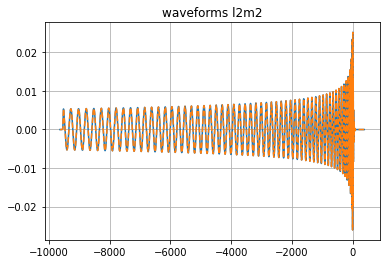

Mismatch is 0.0010368191633691737
--------------------------
Mode l3m3
--------------------------


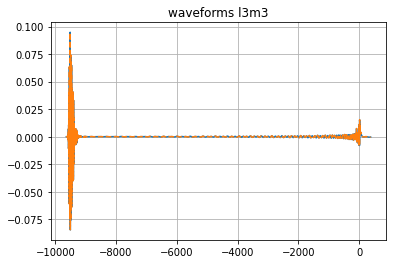

Mismatch is 0.019182561471964288
--------------------------
Mode l4m2
--------------------------


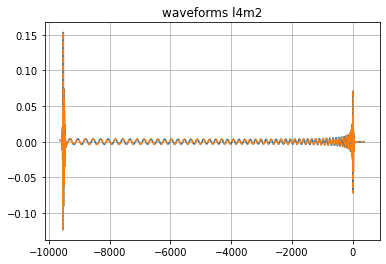

ok

----------------------------------------------------------------------
Ran 1 test in 1.738s

OK


Mismatch is 0.035030921561518547


In [102]:
import unittest


class TestSXS(unittest.TestCase):
    ''' Test loading of SXS waveforms '''
    
    def test_modes(self):
        ''' Test the SXS loading of waveforms against 
        that loading using waveformtools. Tested are RMS errors, maximum deviation and mismatches'''
        
        modes = [(2, 2), (3, 3), (4, 2)]
        #modes = [(2, 2)]
        
        
        for item in modes:
            ell, emm = item
            
            print('--------------------------')
            print(f'Mode l{ell}m{emm}')
            print('--------------------------')
            
            waveforms = GetModesToCompare(ell, emm)
            
            wf1_p = waveforms['wf1p']
            wf1_x = waveforms['wf1x']
            wf2_p = waveforms['wf2p']
            wf2_x = waveforms['wf2x']
            
            wf1_nrcat = wf1_p + 1j*wf1_x
            wf2_wftools = wf2_p + 1j*wf2_x
            
            
            # L2 errors
            Res_p, Amin_p, Amax_p = RMSerrs(np.array(wf1_p), np.array(wf2_p))
            Res_x, Amin_x, Amax_x = RMSerrs(np.array(wf1_x), np.array(wf2_x))

            #Amin_p/=A1max
            #Amin
            # Match
            match_p, shift_p = match(wf1_p, wf2_p)
            match_x, shift_x = match(wf1_x, wf2_x)

            mismatch_p = 100*(1-match_p)
            mismatch_x = 100*(1-match_x)

            max_mismatch = max(mismatch_p, mismatch_x)

            print(f'Mismatch is {max_mismatch}')

            prec = 2
            # RMS error should be less than 0.01 x Amax(wf1)
            self.assertAlmostEqual(Res_p, 0, prec, f"The RMS error between the + components of the waveforms must be atmost 1e-{prec} times Max amplitude of the normalized waveform")
            self.assertAlmostEqual(Res_x, 0, prec, f"The RMS error between the x components of the waveforms must be almost 1e-{prec} times Max amplitude of the normalized waveform")

            prec = 0
            # Max relative point-wise deviation w.r.t Amax(wf1) should be less than 1 (100)%
            self.assertAlmostEqual(np.absolute(Amin_p), 0, prec, f"The maximum lower deviation between the + components of the waveforms must be almost 1e-{prec}%")
            self.assertAlmostEqual(np.absolute(Amax_x), 0, prec, f"The maximum upper deviation between the x components of the waveforms must be almost 1e-{prec}%")

            self.assertAlmostEqual(np.absolute(Amax_p), 0, prec, f"The maximum upper deviation between the + components of the waveforms must be almost 1e-{prec}")
            self.assertAlmostEqual(np.absolute(Amax_x), 0, prec, f"The maximum upper deviation between the x components of the waveforms must be almost 1e-{prec}")

            prec = 1
            # Mismatch should be less than 1e-3 or 1e-1 %
            self.assertAlmostEqual(mismatch_p, 0, prec, f'The mismatch between the + components of the waveforms must be atmost 1e-{prec}%')
            self.assertAlmostEqual(mismatch_x, 0, prec, f"The mismatch between the x components of the waveforms must be atmost 1e-{prec}%")

            #print(wf1_nrcat)
            prec = 2
            # Full arrays must agree pointwiswe
            np.testing.assert_almost_equal(np.array(wf1_nrcat), np.array(wf2_wftools), prec, f'The arrays must equal atleast upto {prec} decimals')

    if __name__ == '__main__':
        unittest.main(argv=['first-arg-is-ignored'], exit=False, verbosity=3)